In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

from einops import rearrange

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")

Load test dataset and network weights:

In [2]:
ckpt = "/home/twhit/bliss/WeakLensingFlowMatchingDC2/scaled_fm_lr0001_redbin3/checkpoints/encoder_230.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("config_dc2_redbin3_flowmatching", {
        "train.pretrained_weights=" + ckpt,
        })

seed = torch.randint(0, 1000, [1])
GlobalEnv.seed_in_this_program = seed

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()
num_batches = len(test_dl)

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Sample shear and convergence maps for each test image:

In [5]:
torch.manual_seed(0)

num_samples_per_image = 4000
num_time_steps = 50

all_z_cpu = []
all_z1_cpu = []
all_batch_indices = []

ra = torch.zeros(len(test_dl), 8, 8, 3, device=device)
dec = torch.zeros(len(test_dl), 8, 8, 3, device=device)

for batch_idx, batch_data in enumerate(test_dl):
    print(f"Processing batch {batch_idx + 1}/{num_batches}")
    
    batch = move_data_to_device(batch_data, device)
    
    x_list = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
    x = torch.cat(x_list, dim=2)
    
    x_embedding = encoder.image_encoder(x)
    
    ra[batch_idx] = batch['tile_catalog']['ra'].squeeze()
    dec[batch_idx] = batch['tile_catalog']['dec'].squeeze()

    shear1 = 100 * rearrange(batch["tile_catalog"]['shear_1'], 'b h w r -> b r h w')
    shear2 = 100 * rearrange(batch["tile_catalog"]['shear_2'], 'b h w r -> b r h w')
    convergence = 100 * rearrange(batch["tile_catalog"]['convergence'], 'b h w r -> b r h w')
    z1 = torch.cat([shear1, shear2, convergence], dim=1)
    
    encoder.image_encoder = encoder.image_encoder.to(cpu_device)
    x = x.to(cpu_device)
    batch = move_data_to_device(batch, cpu_device)
    del x_list
    shear1, shear2, convergence = shear1.to(cpu_device), shear2.to(cpu_device), convergence.to(cpu_device)
    torch.cuda.empty_cache()
    
    t = torch.linspace(0.0, 1.0, num_time_steps + 1, device=device).view(-1, 1, 1).expand(-1, num_samples_per_image, 1)
    x_embedding_expanded = x_embedding.expand(num_samples_per_image, -1, z1.shape[-2], z1.shape[-1])
    z = torch.randn(num_samples_per_image, z1.shape[1], z1.shape[2], z1.shape[3], device=device)
    
    for i in range(num_time_steps):
        with torch.no_grad():
            z = encoder.sample_path(z, x_embedding_expanded, t[i], t[i+1], method='midpoint')
    
    all_z_cpu.append(z.to(cpu_device))
    all_z1_cpu.append(z1.to(cpu_device))
    all_batch_indices.append(batch_idx)

    del z, x_embedding_expanded, t, x_embedding, z1
    encoder.image_encoder = encoder.image_encoder.to(device)
    torch.cuda.empty_cache()
    
    print(f"Batch {batch_idx + 1} complete.")

Processing batch 1/40
Batch 1 complete.
Processing batch 2/40
Batch 2 complete.
Processing batch 3/40
Batch 3 complete.
Processing batch 4/40
Batch 4 complete.
Processing batch 5/40
Batch 5 complete.
Processing batch 6/40
Batch 6 complete.
Processing batch 7/40
Batch 7 complete.
Processing batch 8/40
Batch 8 complete.
Processing batch 9/40
Batch 9 complete.
Processing batch 10/40
Batch 10 complete.
Processing batch 11/40
Batch 11 complete.
Processing batch 12/40
Batch 12 complete.
Processing batch 13/40
Batch 13 complete.
Processing batch 14/40
Batch 14 complete.
Processing batch 15/40
Batch 15 complete.
Processing batch 16/40
Batch 16 complete.
Processing batch 17/40
Batch 17 complete.
Processing batch 18/40
Batch 18 complete.
Processing batch 19/40
Batch 19 complete.
Processing batch 20/40
Batch 20 complete.
Processing batch 21/40
Batch 21 complete.
Processing batch 22/40
Batch 22 complete.
Processing batch 23/40
Batch 23 complete.
Processing batch 24/40
Batch 24 complete.
Processing

In [6]:
# Stack all samples and ground truth
z_cpu = torch.cat([l.unsqueeze(0) for l in all_z_cpu], dim=0).flip(dims=[-2,-1])
z1_cpu = torch.cat(all_z1_cpu, dim=0).unsqueeze(1).flip(dims=[-2,-1])
ra = ra.flip(dims=[1,2]).cpu()
dec = dec.flip(dims=[1,2]).cpu()

# Clean up intermediate lists to free memory
del all_z_cpu, all_z1_cpu, all_batch_indices

In [7]:
encoder.image_encoder = encoder.image_encoder.to(cpu_device)
torch.cuda.empty_cache()

For all three redshift bins, plot the posterior mean convergence map and a few posterior samples:

In [8]:
mask = (dec[...,0] > -36.4).all([-1,-2])
ra_subset = ra[mask]
dec_subset = dec[mask]
shear1_true_subset = rearrange(z1_cpu.squeeze()[:,0:3][mask], 'b d h w -> b h w d') / 100
shear1_pred_subset = rearrange(z_cpu[:,:,0:3][mask], 'b n d h w -> b n h w d') / 100
shear2_true_subset = rearrange(z1_cpu.squeeze()[:,3:6][mask], 'b d h w -> b h w d') / 100
shear2_pred_subset = rearrange(z_cpu[:,:,3:6][mask], 'b n d h w -> b n h w d') / 100
convergence_true_subset = rearrange(z1_cpu.squeeze()[:,6:9][mask], 'b d h w -> b h w d') / 100
convergence_pred_subset = rearrange(z_cpu[:,:,6:9][mask], 'b n d h w -> b n h w d') / 100

In [9]:
ra_mean = ra_subset[...,0].mean([-1,-2])
dec_mean = dec_subset[...,0].mean([-1,-2])
radec_mean = torch.stack((ra_mean, dec_mean), dim=-1)
sorted_indices = torch.argsort(- radec_mean[:,1] * 1e5 + radec_mean[:,0])

In [10]:
ra_subset_sorted = rearrange(ra_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
dec_subset_sorted = rearrange(dec_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_true_subset_sorted = rearrange(shear1_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_pred_subset_sorted = rearrange(shear1_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")
shear2_true_subset_sorted = rearrange(shear2_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear2_pred_subset_sorted = rearrange(shear2_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")
convergence_true_subset_sorted = rearrange(convergence_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
convergence_pred_subset_sorted = rearrange(convergence_pred_subset[sorted_indices].view(6,4,num_samples_per_image,8,8,3), "h w ns nh nw b -> (h nh) (w nw) b ns")

In [11]:
torch.save(shear1_pred_subset_sorted, "fm_shear1_pred_subset_sorted.pt")
torch.save(shear2_pred_subset_sorted, "fm_shear2_pred_subset_sorted.pt")
torch.save(convergence_pred_subset_sorted, "fm_convergence_pred_subset_sorted.pt")

In [12]:
vmin = -0.06
vmax = 0.06
fontsize = 32
ticklabelsize = 16
interpolation = 'none'

extent = [ra_subset_sorted.min().cpu(), ra_subset_sorted.max().cpu(),
          dec_subset_sorted.min().cpu(), dec_subset_sorted.max().cpu()]

/tmp/ipykernel_1621668/2012414780.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  _ = fig.tight_layout()


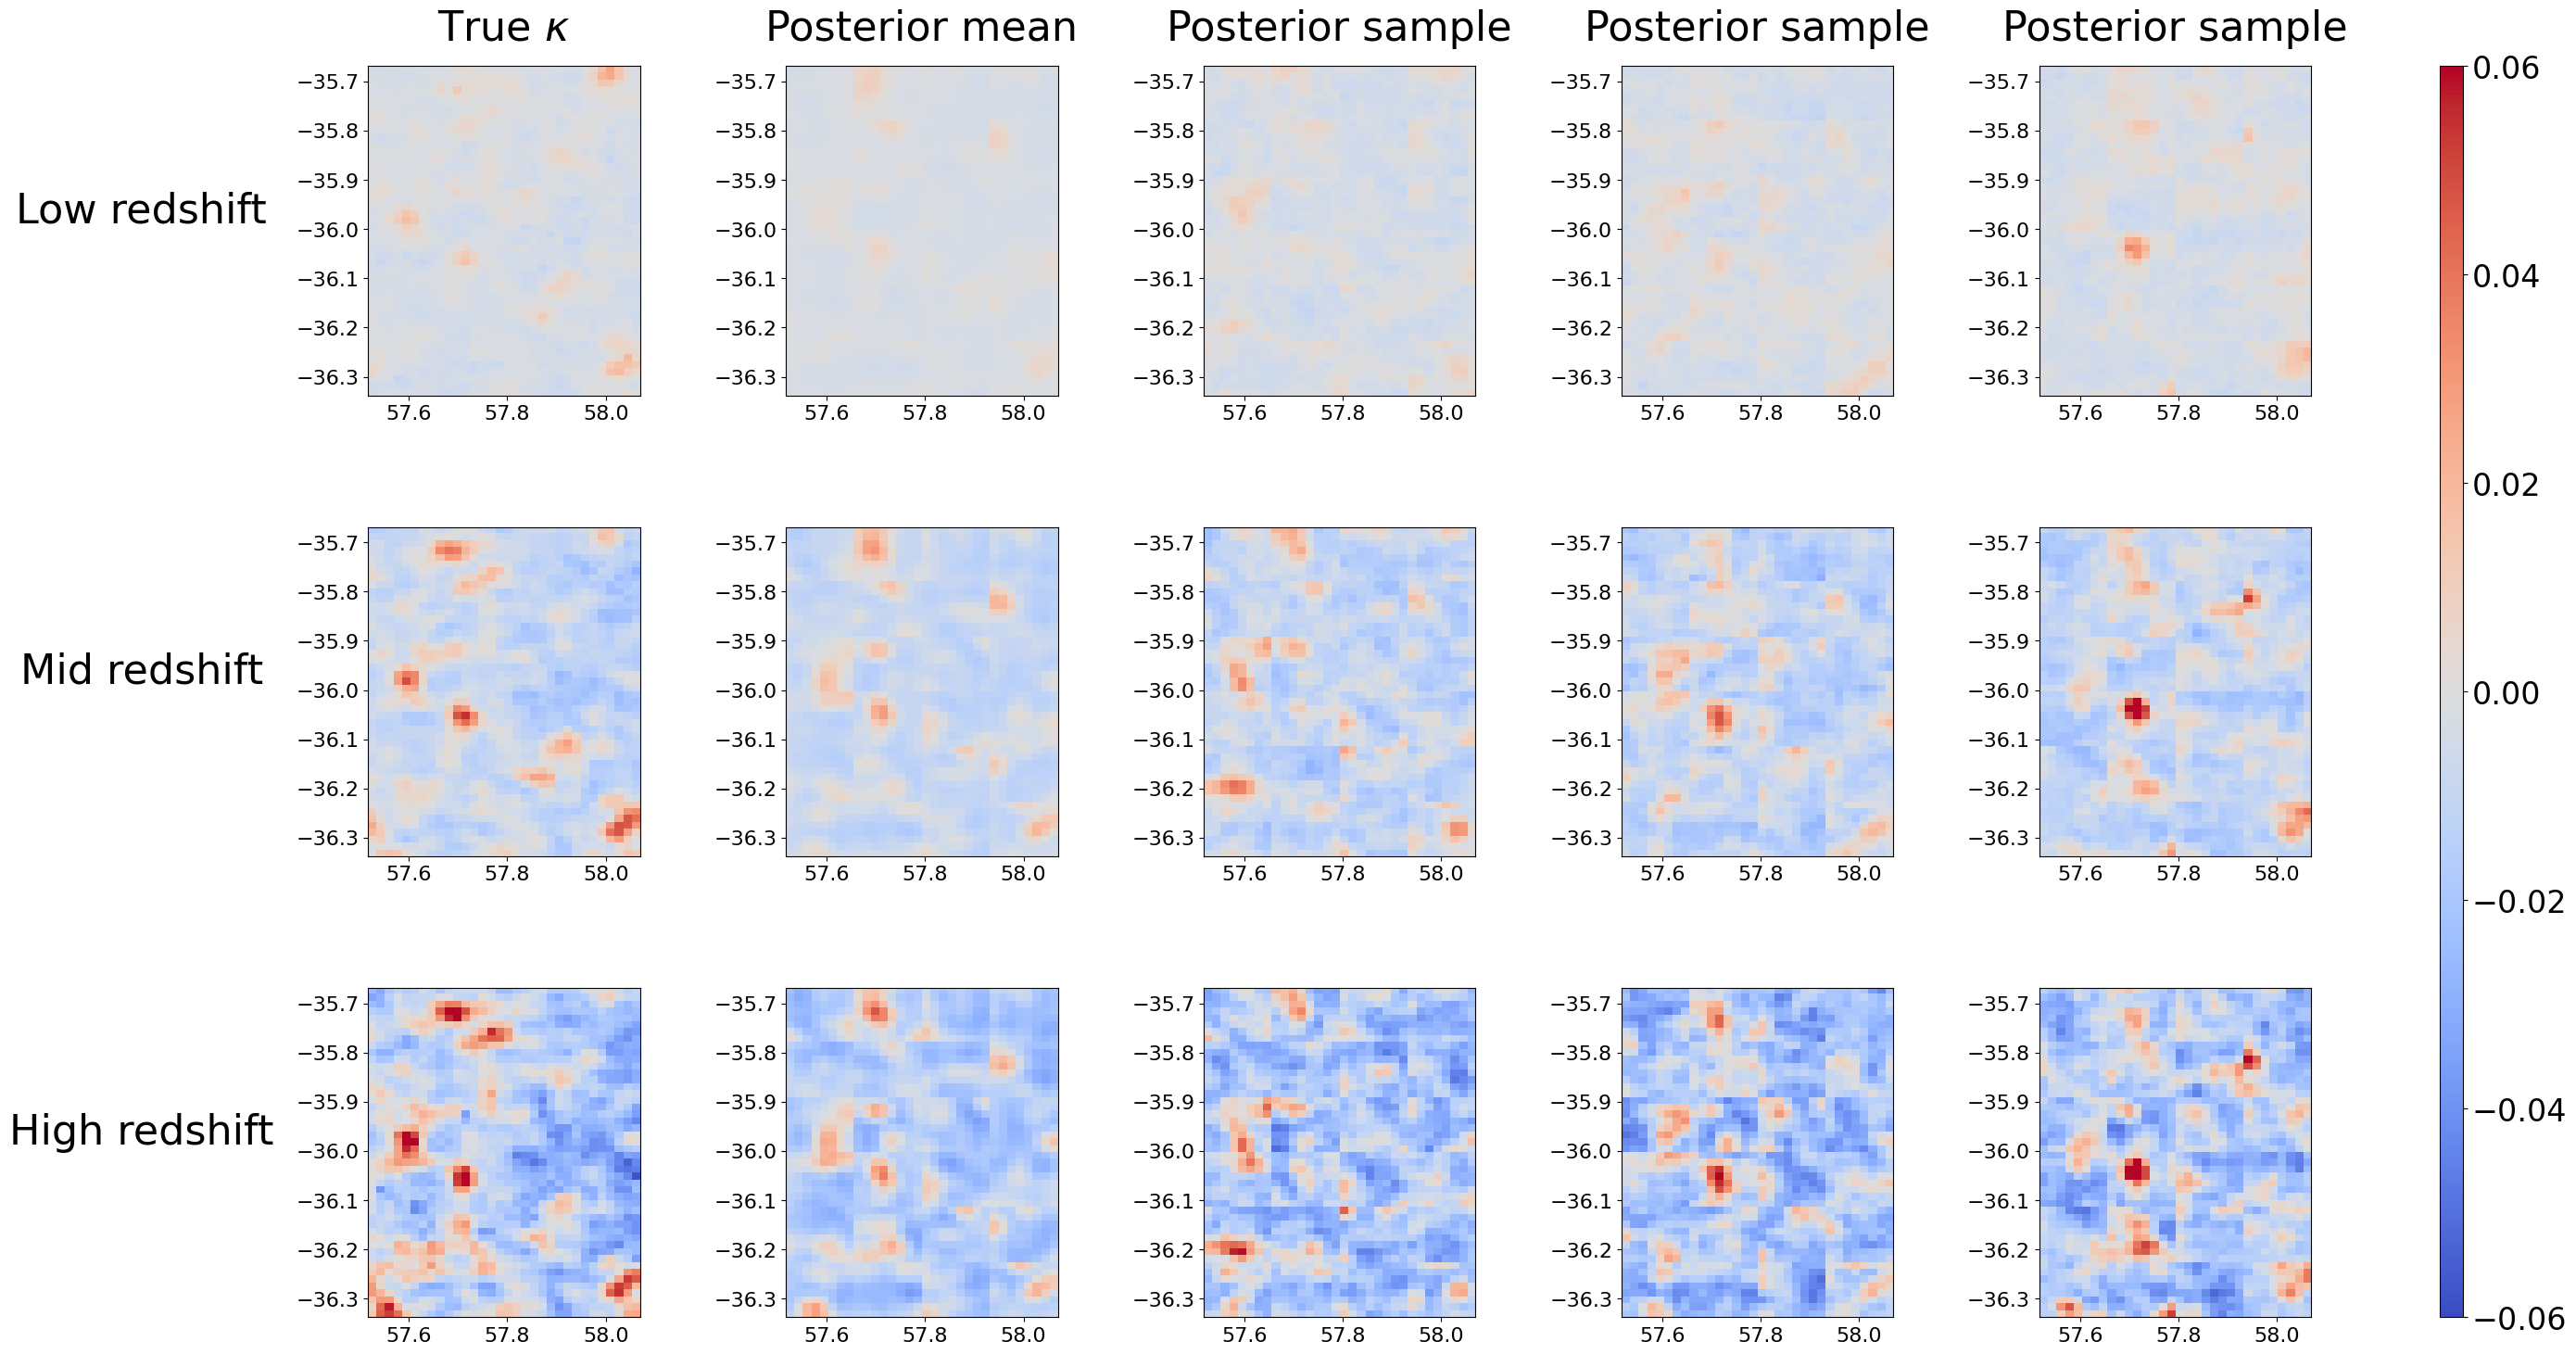

In [13]:
fig, ax = plt.subplots(3, 5, figsize = (25,15))

torch.manual_seed(42)

sample_idx = torch.randint(0, num_samples_per_image, [3])

for b in range(3):
    # True
    _ = ax[b,0].imshow(convergence_true_subset_sorted[...,b].cpu(), extent = extent,
                    interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Posterior mean
    _ = ax[b,1].imshow(convergence_pred_subset_sorted.mean(-1)[...,b].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 1
    _ = ax[b,2].imshow(convergence_pred_subset_sorted[...,b,sample_idx[0]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 2
    _ = ax[b,3].imshow(convergence_pred_subset_sorted[...,b,sample_idx[1]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
    
    # Sample 3
    tmp = ax[b,4].imshow(convergence_pred_subset_sorted[...,b,sample_idx[2]].cpu(), extent = extent,
                       interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')

_ = ax[0,0].set_title('True $\kappa$', fontsize = fontsize, pad = 20)
_ = ax[0,1].set_title('Posterior mean', fontsize = fontsize, pad = 20)
_ = ax[0,2].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,3].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,4].set_title('Posterior sample', fontsize = fontsize, pad = 20)
_ = ax[0,0].set_ylabel('Low redshift', fontsize = fontsize, rotation = 0, labelpad = 120)
_ = ax[1,0].set_ylabel('Mid redshift', fontsize = fontsize, rotation = 0, labelpad = 120)
_ = ax[2,0].set_ylabel('High redshift', fontsize = fontsize, rotation = 0, labelpad = 120)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize = 0.5 * (ticklabelsize + fontsize))
fig.colorbar(tmp, cax=cbar_ax)

_ = fig.tight_layout()

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.01, hspace=0.4)

for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=ticklabelsize)

Construct 90% credible intervals and compute empirical coverage probabilities:

In [14]:
shear1_true = rearrange(z1_cpu.squeeze()[:,0:3], 'b d h w -> b h w d') / 100
shear1_pred = rearrange(z_cpu[:,:,0:3], 'b n d h w -> b n h w d') / 100
shear2_true = rearrange(z1_cpu.squeeze()[:,3:6], 'b d h w -> b h w d') / 100
shear2_pred = rearrange(z_cpu[:,:,3:6], 'b n d h w -> b n h w d') / 100
convergence_true = rearrange(z1_cpu.squeeze()[:,6:9], 'b d h w -> b h w d') / 100
convergence_pred = rearrange(z_cpu[:,:,6:9], 'b n d h w -> b n h w d') / 100

In [15]:
confidence_levels = torch.linspace(0.05, 0.95, 19)

In [16]:
shear1_ci_lower = shear1_pred.quantile(q = (1.0-confidence_levels) / 2.0, dim = 1)
shear1_ci_upper = shear1_pred.quantile(q = 1.0 - (1.0 - confidence_levels) / 2.0, dim = 1)
shear2_ci_lower = shear2_pred.quantile(q = (1.0-confidence_levels) / 2.0, dim = 1)
shear2_ci_upper = shear2_pred.quantile(q = 1.0 - (1.0 - confidence_levels) / 2.0, dim = 1)
convergence_ci_lower = convergence_pred.quantile(q = (1.0-confidence_levels) / 2.0, dim = 1)
convergence_ci_upper = convergence_pred.quantile(q = 1.0 - (1.0 - confidence_levels) / 2.0, dim = 1)

In [17]:
shear1_coverage_probs = ((shear1_ci_lower <= shear1_true.unsqueeze(0)) * (shear1_true.unsqueeze(0) <= shear1_ci_upper)).float().mean([1,2,3])
shear2_coverage_probs = ((shear2_ci_lower <= shear2_true.unsqueeze(0)) * (shear2_true.unsqueeze(0) <= shear2_ci_upper)).float().mean([1,2,3])
convergence_coverage_probs = ((convergence_ci_lower <= convergence_true.unsqueeze(0)) * (convergence_true.unsqueeze(0) <= convergence_ci_upper)).float().mean([1,2,3])

In [18]:
torch.save(shear1_coverage_probs, "fm_shear1_coverage_probs.pt")
torch.save(shear2_coverage_probs, "fm_shear2_coverage_probs.pt")
torch.save(convergence_coverage_probs, "fm_convergence_coverage_probs.pt")

In [19]:
for b in range(3):
    print(f'Redshift bin {b}:')
    for i, ci in enumerate(confidence_levels):
        print(f'Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i,b]:.4f}, Shear 2: {shear2_coverage_probs[i,b]:.4f}, Convergence: {convergence_coverage_probs[i,b]:.4f}')
    print('\n')

Redshift bin 0:
Confidence level: 0.05, Shear 1: 0.0617, Shear 2: 0.0516, Convergence: 0.0543
Confidence level: 0.10, Shear 1: 0.1195, Shear 2: 0.1055, Convergence: 0.1137
Confidence level: 0.15, Shear 1: 0.1828, Shear 2: 0.1504, Convergence: 0.1809
Confidence level: 0.20, Shear 1: 0.2414, Shear 2: 0.2051, Convergence: 0.2406
Confidence level: 0.25, Shear 1: 0.2914, Shear 2: 0.2488, Convergence: 0.2977
Confidence level: 0.30, Shear 1: 0.3477, Shear 2: 0.3047, Convergence: 0.3520
Confidence level: 0.35, Shear 1: 0.3949, Shear 2: 0.3570, Convergence: 0.4035
Confidence level: 0.40, Shear 1: 0.4391, Shear 2: 0.4082, Convergence: 0.4543
Confidence level: 0.45, Shear 1: 0.4930, Shear 2: 0.4551, Convergence: 0.5016
Confidence level: 0.50, Shear 1: 0.5437, Shear 2: 0.5043, Convergence: 0.5539
Confidence level: 0.55, Shear 1: 0.5875, Shear 2: 0.5480, Convergence: 0.5980
Confidence level: 0.60, Shear 1: 0.6391, Shear 2: 0.5930, Convergence: 0.6449
Confidence level: 0.65, Shear 1: 0.6934, Shear 2

In [20]:
shear1_ci_lower_flat = rearrange(shear1_ci_lower, 'c n h w r -> n (h w) r c')
shear1_ci_upper_flat = rearrange(shear1_ci_upper, 'c n h w r -> n (h w) r c')
shear1_true_flat = rearrange(shear1_true, 'n h w r -> n (h w) r')
shear2_ci_lower_flat = rearrange(shear2_ci_lower, 'c n h w r -> n (h w) r c')
shear2_ci_upper_flat = rearrange(shear2_ci_upper, 'c n h w r -> n (h w) r c')
shear2_true_flat = rearrange(shear2_true, 'n h w r -> n (h w) r')
convergence_ci_lower_flat = rearrange(convergence_ci_lower, 'c n h w r -> n (h w) r c')
convergence_ci_upper_flat = rearrange(convergence_ci_upper, 'c n h w r -> n (h w) r c')
convergence_true_flat = rearrange(convergence_true, 'n h w r -> n (h w) r')

Redshift bin 0:

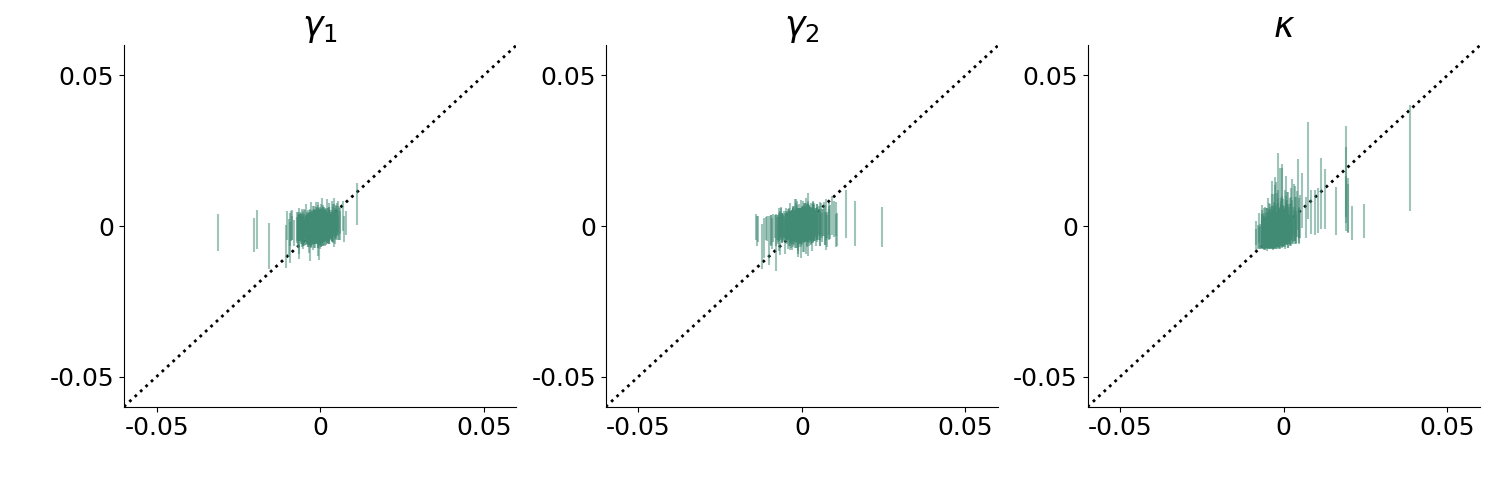

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fontsize = 25
ticklabelsize = 18
color = np.array(['#418a74','#418a74'])
alpha = 0.5

# Specify redshift bin
b = 0

axmin = -0.06
axmax = 0.06

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_ylabel(r'Posterior interval', fontsize=fontsize, color = 'white')
_ = ax[0].set_title('$\gamma_1$', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('Ground truth', fontsize=fontsize, color = 'white')
_ = ax[1].set_title('$\gamma_2$', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower_flat[:,:,b,:].flatten(0,1) <= convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_title('$\kappa$', fontsize=fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}_fm.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 1:

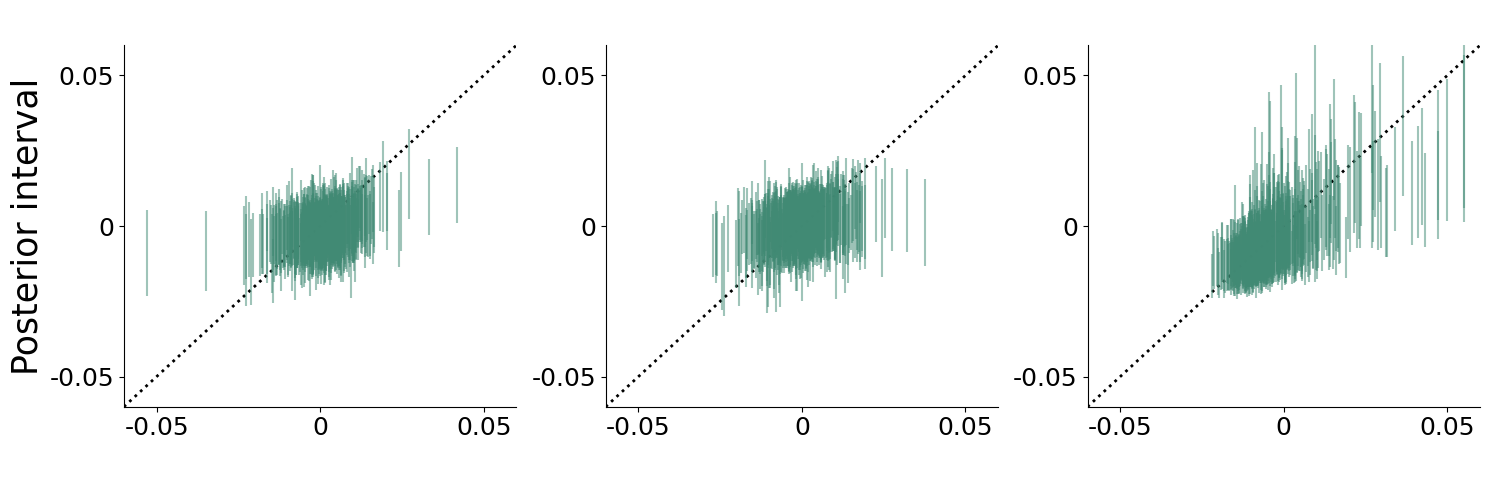

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fontsize = 25
ticklabelsize = 18
color = np.array(['#418a74','#418a74'])
alpha = 0.5

# Specify redshift bin
b = 1

axmin = -0.06
axmax = 0.06

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_ylabel(r'Posterior interval', fontsize=fontsize)
_ = ax[0].set_title('$\gamma_1$', fontsize=fontsize, color = 'white')
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('Ground truth', fontsize=fontsize, color = 'white')
_ = ax[1].set_title('$\gamma_2$', fontsize=fontsize, color = 'white')
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower_flat[:,:,b,:].flatten(0,1) <= convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_title('$\kappa$', fontsize=fontsize, color = 'white')
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}_fm.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 2:

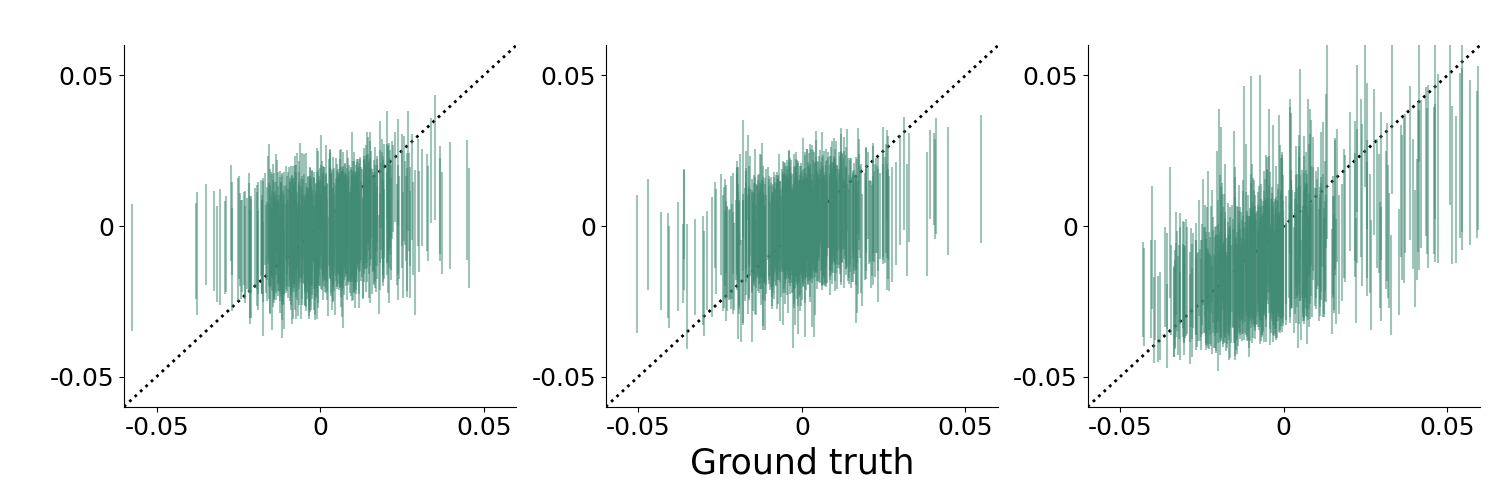

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fontsize = 25
ticklabelsize = 18
color = np.array(['#418a74','#418a74'])
alpha = 0.5

# Specify redshift bin
b = 2

axmin = -0.06
axmax = 0.06

np.random.seed(0)
indexes = np.random.choice(len(test_dl) * 64, 500, replace=False) # show credible intervals for 500 randomly selected tiles

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear1_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear1_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear1_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_ylabel(r'Posterior interval', fontsize=fontsize, color = 'white')
_ = ax[0].set_title('$\gamma_1$', fontsize=fontsize, color = 'white')
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower_flat[:,:,b,:].flatten(0,1) <= shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (shear2_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= shear2_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = shear2_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('Ground truth', fontsize=fontsize)
_ = ax[1].set_title('$\gamma_2$', fontsize=fontsize, color = 'white')
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)



_ = ax[2].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
convergence_coverage = (
    ((convergence_ci_lower_flat[:,:,b,:].flatten(0,1) <= convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1)
        ) * (convergence_true_flat[...,b].flatten(0,1).unsqueeze(-1) <= convergence_ci_upper_flat[:,:,b,:].flatten(0,1)))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (convergence_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"covers ({round(100 * convergence_coverage_probs[interval_idx,b].item(), 1)}%)")
    elif (not convergence_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - convergence_coverage_probs[interval_idx,b].item()), 1)}%)")
    else:
        _ = ax[2].vlines(x = convergence_true_flat[...,b].flatten(0,1)[indexes[i]],
                        ymin = convergence_ci_lower_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        ymax = convergence_ci_upper_flat[:,:,b,:].flatten(0,1)[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[convergence_coverage[indexes[i]]])
_ = ax[2].set_title('$\kappa$', fontsize=fontsize, color = 'white')
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
_ = ax[2].set_xlim(axmin, axmax)
_ = ax[2].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/credibleintervals_bin{b}_fm.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)